# Risk Based Authentication 

Trabalho Realizado por:

- Bernardo Coelho nº 98445
- Francisco Camilo nº99234
- Simão Miguel nº 99064
- Tiago Coelho nº 105176


A nossa base de dados escolhida é relativa a histórico de tentativas de login.
Foi definido ao longo do projeto que o objetivo seria determinar se um login poderia ser ou não um ataque de IP

Para tal fizemos 4 notebooks , cada um com objetivos diferente:
- Extract, transform and load (ETL)- neste notebook irá ser feita uma limpeza e tratamento, serão escolhidas as variáveis a utiizar para o modelo
- Análise exploratória-> neste notebook iremos verificar e analisar os dados
- Treino e afinação do modelo -> nestenotebook irá ser criado o modelo para o objetivo final de determinar se se um login pode ser ou não um ataque de IP
- Deployment do modelo -> iremos ver os resultados do modelo


In [14]:

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

In [2]:
# build our SparkSession

spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [3]:
output = spark.read.parquet('/home/jovyan/code/Projeto/model_db.parquet')

In [4]:
output.show()

+----------+-------+---------+--------------+------------+--------------+------------+----------------+--------------------+
|hashed_ASN|dtIndex|hashed_OS|hashed_browser|Dangerous IP|ip_class_index|Is Attack IP|Login Successful|            features|
+----------+-------+---------+--------------+------------+--------------+------------+----------------+--------------------+
|        53|    0.0|       22|            61|       false|           0.0|           0|            true|[53.0,0.0,22.0,61...|
|         0|    0.0|       60|           345|       false|           0.0|           0|           false|(7,[2,3],[60.0,34...|
|        43|    0.0|       36|           286|       false|           0.0|           0|           false|(7,[0,2,3],[43.0,...|
|        53|    1.0|       37|            31|       false|           0.0|           0|           false|[53.0,1.0,37.0,31...|
|        53|    1.0|       37|            97|       false|           0.0|           0|           false|[53.0,1.0,37.0,97...|


# Modelo de classificação

### Iremos agora então criar o modelo para prever se o login pode ser considerado ataque ou não

## Regressão Logística

In [5]:
train, test = output.randomSplit([0.8, 0.2], seed=17)

In [6]:
print("Size of trainning data:",train.count())
print("Size of test data:",test.count())

Size of trainning data: 1251060
Size of test data: 312547


In [7]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'Is Attack IP', maxIter=10)

In [9]:
pipeline = Pipeline(stages=[lr])

# Train the model
pipelineModel = pipeline.fit(train)

# Save the trained pipeline model
pipelineModel.write().overwrite().save('/home/jovyan/code/Projeto/pipeline')


In [10]:
output_logins = "test.parquet"
test.write.mode("overwrite").parquet(output_logins)

In [11]:
lrModel = lr.fit(train)

In [12]:
lrModel

LogisticRegressionModel: uid=LogisticRegression_22425f42297a, numClasses=2, numFeatures=7

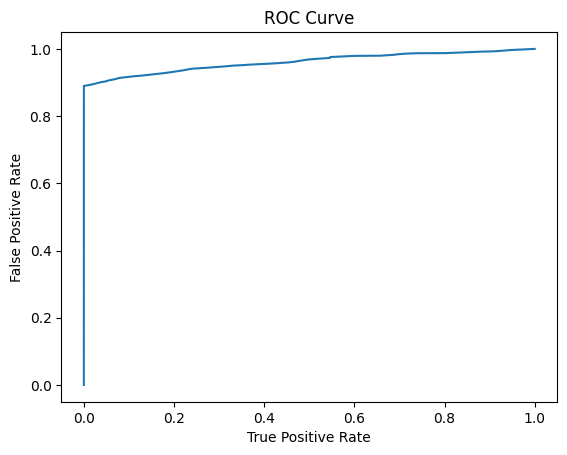

Training set areaUnderROC: 0.960926496064776


In [15]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

A ROC indica que o seu classificador tem um bom desempenho, pois atinge uma alta taxa de True Positive com uma taxa de False Positive relativamente baixa em grande parte dos limiares.
A área sob a curva, como é 0.96, indica que temos um classificar quase perfeito (perto de 1).

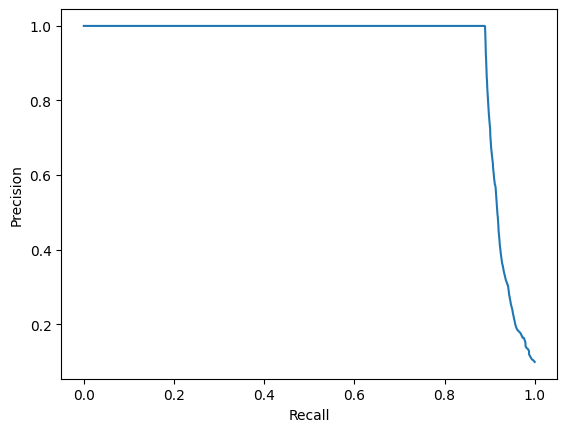

In [17]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

A curva PR (Precision-Recall) mostra que o modelo mantém uma alta precisão (próxima de 1) até que o recall atinja cerca de 0.8. Após esse ponto, a precisão começa a diminuir rapidamente, indicando que a maioria das previsões adicionais feitas para aumentar o recall são False Positive.